In [ ]:
!pip install transformers[torch] datasets accelerate -q
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 -q

In [ ]:
# Setup and imports
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Transformers
from transformers import (
    AutoTokenizer,
    AutoModel,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from datasets import load_dataset, Dataset as HFDataset

# Metrics
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix
)
from sklearn.model_selection import train_test_split

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
print(f"PyTorch version: {torch.__version__}")
print("Ready!")

Device: cpu
PyTorch version: 2.9.0+cpu
Ready!


In [ ]:
# Set random seeds for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

In [ ]:
def scaled_dot_product_attention(query, key, value, mask=None):

    """
    Compute scaled dot-product attention.

    Args:
        query: Tensor of shape (batch_size, seq_len_q, d_k)
        key: Tensor of shape (batch_size, seq_len_k, d_k)
        value: Tensor of shape (batch_size, seq_len_k, d_v)
        mask: Optional mask tensor

    Returns:
        output: Tensor of shape (batch_size, seq_len_q, d_v)
        attention_weights: Tensor of shape (batch_size, seq_len_q, seq_len_k)
    """
    # TODO: Implement
    # 1. Compute attention scores: QK^T
    # 2. Scale by sqrt(d_k)
    # 3. Apply mask if provided (set masked positions to -inf)
    # 4. Apply softmax
    # 5. Multiply by V

    scores = torch.matmul(query, key.transpose(-2, -1))

    dk = query.size(-1)
    scores = scores / math.sqrt(dk)

    if mask is not None:

        scores = scores.masked_fill(mask == 0, float('-inf'))

    attention_weights = F.softmax(scores, dim=-1)

    output = torch.matmul(attention_weights, value)

    return output, attention_weights



batch_size, seq_len, d_k = 2, 4, 8
Q = torch.randn(batch_size, seq_len, d_k)
K = torch.randn(batch_size, seq_len, d_k)
V = torch.randn(batch_size, seq_len, d_k)

output, attn_weights = scaled_dot_product_attention(Q, K, V)
print(f"Output shape: {output.shape}")  # Expected: (2, 4, 8)
print(f"Attention weights shape: {attn_weights.shape}")  # Expected: (2, 4, 4)
print(f"Attention weights sum (should be ~1): {attn_weights[0, 0].sum():.4f}")


Output shape: torch.Size([2, 4, 8])
Attention weights shape: torch.Size([2, 4, 4])
Attention weights sum (should be ~1): 1.0000


In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):

        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)

        self.W_o = nn.Linear(d_model, d_model)

    def forward(self, query, key, value, mask=None):
        batch_size, seq_len, _ = query.size()

        Q = self.W_q(query)
        K = self.W_k(key)
        V = self.W_v(value)

        Q = Q.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)

        output, attention_weights = scaled_dot_product_attention(Q, K, V, mask)


        output = output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        output = self.W_o(output)

        return output, attention_weights


d_model, num_heads = 64, 8
mha = MultiHeadAttention(d_model, num_heads)

x = torch.randn(2, 10, d_model)
output, attn = mha(x, x, x)

print(f"Input shape: {x.shape}")        # (2, 10, 64)
print(f"Output shape: {output.shape}")  # (2, 10, 64)
print(f"Attention shape: {attn.shape}") # (2, 8, 10, 10)
print(f"Attention sum check: {attn[0,0,0].sum():.4f}")  # ~1

Input shape: torch.Size([2, 10, 64])
Output shape: torch.Size([2, 10, 64])
Attention shape: torch.Size([2, 8, 10, 10])
Attention sum check: 1.0000


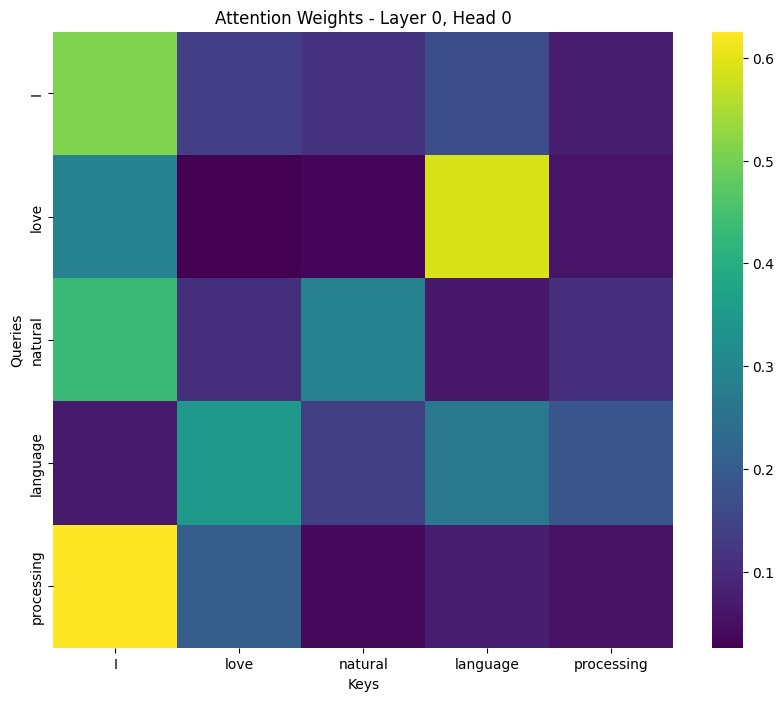

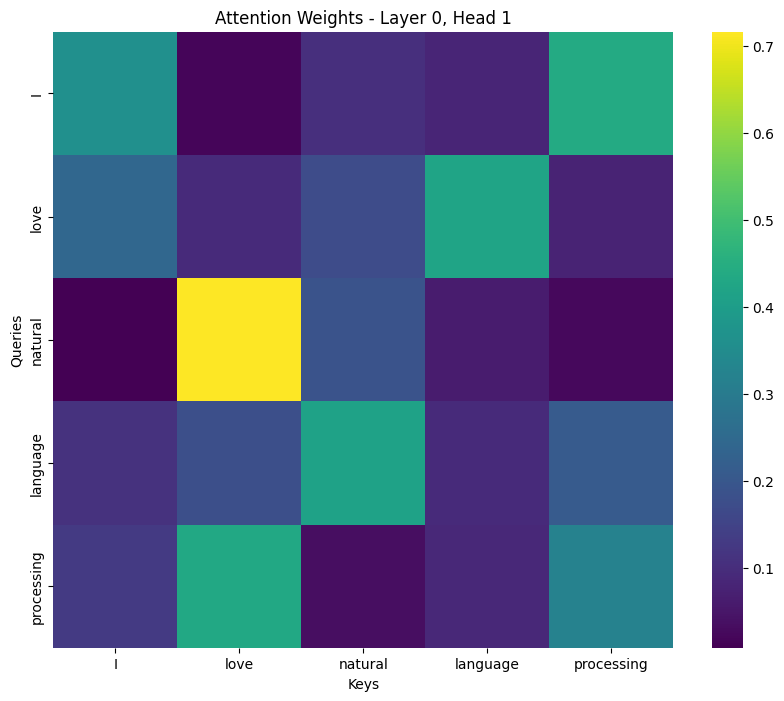

In [ ]:
def visualize_attention(attention_weights, tokens, layer=0, head=0):
    """
    Visualize attention weights as a heatmap.

    Args:
        attention_weights: Tensor of shape (batch, num_heads, seq_len, seq_len)
        tokens: List of token strings
        layer: Which layer to visualize (if multiple)
        head: Which attention head to visualize
    """
    # 1. Extract attention weights for specified head
    attn = attention_weights[0, head].detach().cpu().numpy()

    # 2. Create heatmap using seaborn/matplotlib
    plt.figure(figsize=(10, 8))
    sns.heatmap(attn, xticklabels=tokens, yticklabels=tokens, cmap='viridis', cbar=True)

    # 3. Label axes with tokens
    plt.xlabel("Keys")
    plt.ylabel("Queries")

    # 4. Add title indicating which head is shown
    plt.title(f"Attention Weights - Layer {layer}, Head {head}")
    plt.show()

# Test with sample tokens
sample_tokens = ["I", "love", "natural", "language", "processing"]
seq_len = len(sample_tokens)
sample_attn = torch.softmax(torch.randn(1, 4, seq_len, seq_len), dim=-1)

# Visualize attention for head 0 and head 1
visualize_attention(sample_attn, sample_tokens, head=0)
visualize_attention(sample_attn, sample_tokens, head=1)

In [ ]:
from transformers import AutoTokenizer

# Load tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Sample texts for exploration
sample_texts = [
    "I am feeling happy today!",
    "This is absolutely unbelievable!",
    "The transformers architecture revolutionized NLP."
]

# For each sample text:
# 1. Tokenize and print the tokens
# 2. Print the token IDs
# 3. Decode back to text
# 4. Show special tokens ([CLS], [SEP], [PAD])

for text in sample_texts:
    print(f"\nOriginal: {text}")

    tokens = tokenizer.tokenize(text)
    print(f"Tokens: {tokens}")

    token_ids = tokenizer.encode(text)
    print(f"Token IDs: {token_ids}")

    decoded_text = tokenizer.decode(token_ids)
    print(f"Decoded: {decoded_text}")

    print(f"Special tokens: [CLS]={tokenizer.cls_token} (ID: {tokenizer.cls_token_id}), "
          f"[SEP]={tokenizer.sep_token} (ID: {tokenizer.sep_token_id}), "
          f"[PAD]={tokenizer.pad_token} (ID: {tokenizer.pad_token_id})")

    print(f"Note: In encoded text, [CLS]={token_ids[0]}, [SEP]={token_ids[-1]}")

# Explore subword tokenization
# Tokenize these words and observe how unknown/rare words are split:
test_words = ["happy", "unhappiness", "transformers", "ChatGPT", "tokenization"]

print("\n\nSubword tokenization examples:")
for word in test_words:
    subtokens = tokenizer.tokenize(word)
    token_ids = tokenizer.encode(word, add_special_tokens=False)
    print(f"\nWord: '{word}'")
    print(f"  Subtokens: {subtokens}")
    print(f"  Token IDs: {token_ids}")
    print(f"  Reconstructed: '{tokenizer.decode(token_ids)}'")
    if len(subtokens) > 1:
        print(f"  Split into {len(subtokens)} subword(s)")



config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]


Original: I am feeling happy today!
Tokens: ['i', 'am', 'feeling', 'happy', 'today', '!']
Token IDs: [101, 1045, 2572, 3110, 3407, 2651, 999, 102]
Decoded: [CLS] i am feeling happy today! [SEP]
Special tokens: [CLS]=[CLS] (ID: 101), [SEP]=[SEP] (ID: 102), [PAD]=[PAD] (ID: 0)
Note: In encoded text, [CLS]=101, [SEP]=102

Original: This is absolutely unbelievable!
Tokens: ['this', 'is', 'absolutely', 'unbelievable', '!']
Token IDs: [101, 2023, 2003, 7078, 23653, 999, 102]
Decoded: [CLS] this is absolutely unbelievable! [SEP]
Special tokens: [CLS]=[CLS] (ID: 101), [SEP]=[SEP] (ID: 102), [PAD]=[PAD] (ID: 0)
Note: In encoded text, [CLS]=101, [SEP]=102

Original: The transformers architecture revolutionized NLP.
Tokens: ['the', 'transformers', 'architecture', 'revolution', '##ized', 'nl', '##p', '.']
Token IDs: [101, 1996, 19081, 4294, 4329, 3550, 17953, 2361, 1012, 102]
Decoded: [CLS] the transformers architecture revolutionized nlp. [SEP]
Special tokens: [CLS]=[CLS] (ID: 101), [SEP]=[SEP] 

In [ ]:
model = AutoModel.from_pretrained(model_name)
model.eval()

def get_bert_embedding(text, tokenizer, model, pooling='cls'):
    """
    Get BERT embedding for a text.
    """
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)

    with torch.no_grad():
        outputs = model(**inputs)

    last_hidden_state = outputs.last_hidden_state

    if pooling == 'cls':
        embedding = last_hidden_state[:, 0, :]
    elif pooling == 'mean':
        attention_mask = inputs['attention_mask']
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        embedding = sum_embeddings / sum_mask
    else:
        raise ValueError("Use 'cls' or 'mean'")

    return embedding.squeeze().numpy()

# Test
test_text = "I am feeling excited about learning transformers!"
embedding = get_bert_embedding(test_text, tokenizer, model)
print(f"Embedding shape: {embedding.shape}")  # Expected: (768,)


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Embedding shape: (768,)



Cosine Similarity:
                             I am very happy today  I feel joyful and excited  \
I am very happy today                        1.000                      0.876   
I feel joyful and excited                    0.876                      1.000   
I am sad and depressed                       0.886                      0.905   
The weather is nice outside                  0.936                      0.798   

                             I am sad and depressed  \
I am very happy today                         0.886   
I feel joyful and excited                     0.905   
I am sad and depressed                        1.000   
The weather is nice outside                   0.819   

                             The weather is nice outside  
I am very happy today                              0.936  
I feel joyful and excited                          0.798  
I am sad and depressed                             0.819  
The weather is nice outside                        1.000  


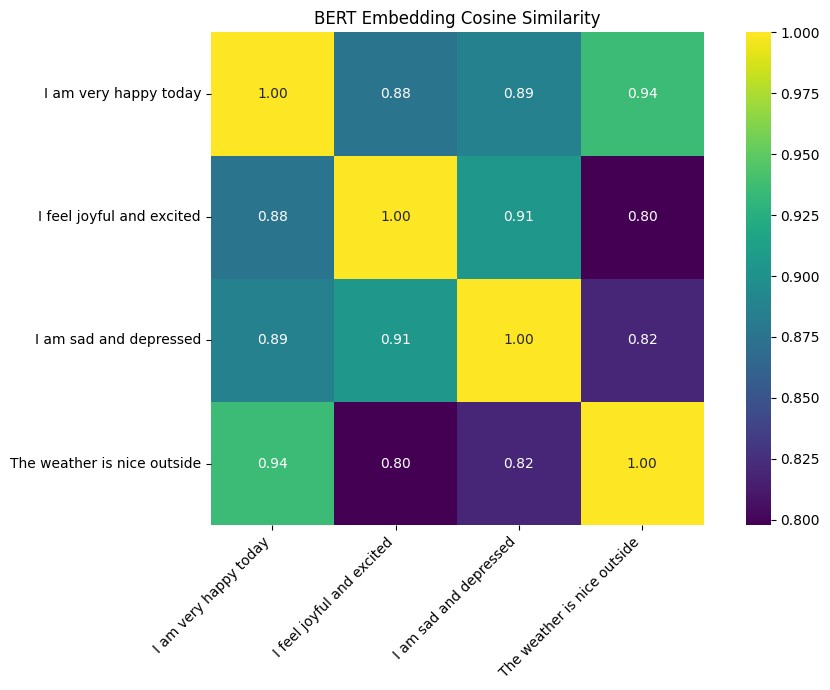

In [ ]:

sentences = [
    "I am very happy today",
    "I feel joyful and excited",
    "I am sad and depressed",
    "The weather is nice outside"
]

embeddings = []
for s in sentences:
    E = get_bert_embedding(s, tokenizer, model, pooling="cls")  # or "mean"
    embeddings.append(E)

embeddings = np.vstack(embeddings)

matrix = cosine_similarity(embeddings)


sim_df = pd.DataFrame(matrix, index=sentences, columns=sentences)
print("\nCosine Similarity:")
print(sim_df.round(3))


plt.figure(figsize=(10, 7))
sns.heatmap(sim_df, annot=True, fmt=".2f", cmap="viridis", square=True)
plt.title("BERT Embedding Cosine Similarity")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


مدل برت آموزش دیده که کلمات ماسک‌شده رو حدس بزنه، نه اینکه جمله‌ها رو در فضا طوری بچینه که تشابه معنایی بدن.

جمله‌ی "هپی" با جمله‌ی "سد" شباهت خیلی بالایی داره

جمله‌ی "ودر" حتی به "هپی" نزدیک‌تره

این یعنی   بیشتر ساختار جمله / کلمات عمومی رو گرفته‌اند تا معنا و احساس.

با استفاده از Mean polling نتایج بهتر می شود.

In [ ]:
from transformers import pipeline

classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

emotion_labels = ["joy", "sadness", "anger", "fear", "surprise", "disgust"]

test_sentences = [
    "I just got promoted at work! This is the best day ever!",
    "I can't believe they cancelled the event. I was looking forward to it.",
    "That driver almost hit me! What is wrong with people?",
    "I heard a strange noise outside my window at night.",
    "Wait, you're telling me I won the lottery?!",
    "The way they treated those animals was horrible."
]


for sent in test_sentences:
    result = classifier(sent, candidate_labels=emotion_labels)

    A = result["labels"][0]
    B = result["scores"][0]

    print(f"Sentence: {sent}")
    print(f"  Predicted emotion: {A}")
    print(f"  Confidence score: {B:.4f}")



Loading weights:   0%|          | 0/515 [00:00<?, ?it/s]

Sentence: I just got promoted at work! This is the best day ever!
  Predicted emotion: surprise
  Confidence score: 0.5370
Sentence: I can't believe they cancelled the event. I was looking forward to it.
  Predicted emotion: surprise
  Confidence score: 0.6145
Sentence: That driver almost hit me! What is wrong with people?
  Predicted emotion: disgust
  Confidence score: 0.3166
Sentence: I heard a strange noise outside my window at night.
  Predicted emotion: surprise
  Confidence score: 0.7261
Sentence: Wait, you're telling me I won the lottery?!
  Predicted emotion: surprise
  Confidence score: 0.8274
Sentence: The way they treated those animals was horrible.
  Predicted emotion: disgust
  Confidence score: 0.6584



طبقه‌بندی‌کننده "زیرو_شات"  پیش‌بینی‌های معقولی برای برخی جملات، به‌ویژه جملاتی که به‌شدت با تعجب مرتبط بودند، ارائه داد. با این حال، اغلب شادی را با تعجب و خشم را با انزجار اشتباه می‌گرفت. این رفتار به این دلیل رخ می‌دهد که مدل برای استنتاج زبان طبیعی آموزش دیده است نه تشخیص احساسات، و به شدت به نشانه‌های واژگانی مانند «باورم نمی‌شود» یا «صبر کن» که نشان‌دهنده تعجب هستند، متکی است. علاوه بر این، دسته‌های احساسات ممکن است با هم همپوشانی داشته باشند و فرض تک‌برچسبی، مدل را مجبور می‌کند حتی زمانی که چندین احساس وجود دارد، یک برچسب را انتخاب کند.

In [ ]:
# Load the emotion dataset from HuggingFace
dataset = load_dataset("emotion")

print("Dataset structure:")
print(dataset)
print(f"\nTraining samples: {len(dataset['train'])}")
print(f"Validation samples: {len(dataset['validation'])}")
print(f"Test samples: {len(dataset['test'])}")

Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

Training samples: 16000
Validation samples: 2000
Test samples: 2000


SADNESS (label=0)
i didnt feel humiliated
i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake
ive been feeling a little burdened lately wasnt sure why that was

JOY (label=1)
i have been with petronas for years i feel that petronas has performed well and made a huge profit
i do feel that running is a divine experience and that i can expect to have some type of spiritual encounter
i have immense sympathy with the general point but as a possible proto writer trying to find time to write in the corners of life and with no sign of an agent let alone a publishing contract this feels a little precious

LOVE (label=2)
i am ever feeling nostalgic about the fireplace i will know that it is still on the property
i feel romantic too
i can t let go of that sad feeling that i want to be accepted here in this first home of mine

ANGER (label=3)
im grabbing a minute to post i feel greedy wrong
i am feeling grouchy
i think it s the easiest time 

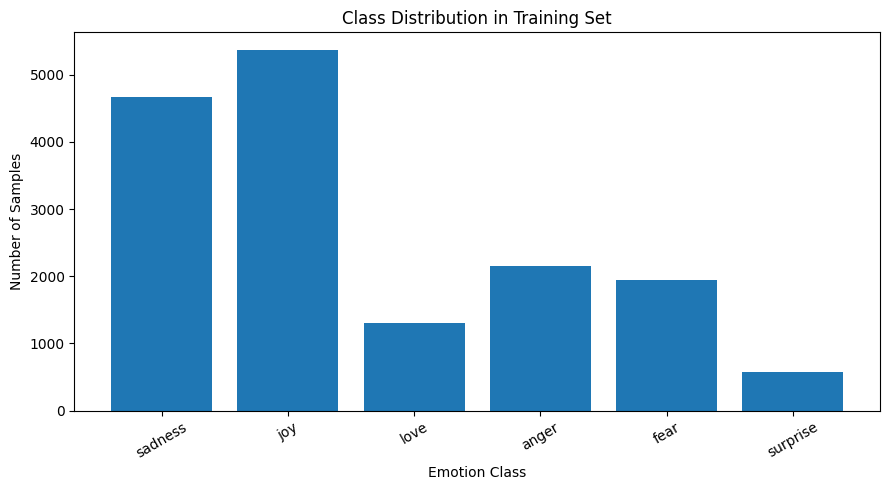


--- Class Distribution ---
label
1    5362
0    4666
3    2159
4    1937
2    1304
5     572
Name: count, dtype: int64

Total samples: 16000
1: 33.51%
0: 29.16%
3: 13.49%
4: 12.11%
2: 8.15%
5: 3.57%


In [ ]:
emotion_labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
num_labels = len(emotion_labels)

# TODO:
# 1. Show 3 example texts for each emotion
# 2. Create a bar plot showing class distribution in training set
# 3. Check for class imbalance - is the dataset balanced?


train_df = pd.DataFrame(dataset["train"])

for id, label in enumerate(emotion_labels):
    examples = train_df[train_df["label"] == id]["text"].head(3).tolist()

    print(f"{label.upper()} (label={id})")
    for i, ex in enumerate(examples, 1):
        print(f"{ex}")
    print()


C = train_df["label"].value_counts().sort_index()
Name = [emotion_labels[i] for i in C.index]

plt.figure(figsize=(9, 5))
plt.bar(Name, C.values)
plt.title("Class Distribution in Training Set")
plt.xlabel("Emotion Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


label_counts = train_df['label'].value_counts()
print("\n--- Class Distribution ---")
print(label_counts)

total = len(train_df)
print(f"\nTotal samples: {total}")
for label, count in label_counts.items():
    percentage = (count / total) * 100
    print(f"{label}: {percentage:.2f}%")


دیتاست بالانس نیست چون همانطور که مشخص است بعضی کلاس ها درصد بیشتری را به خود اختصای می دهند و بعضی کلاس ها درصد کمی دارند.

مثلا برای

joy , sadness:

این دو کلاس درصد بالایی دارند


surprise , love:

درصد کمتری دارند


In [ ]:
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def tokenize_function(examples):
    """
    Tokenize a batch of examples.
    """
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Remove unnecessary columns and set format to torch
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

print("Tokenized dataset:")
print(tokenized_datasets)


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Tokenized dataset:
DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
})


In [ ]:

model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label={i: label for i, label in enumerate(emotion_labels)},
    label2id={label: i for i, label in enumerate(emotion_labels)}
)

print(model)


def count_parameters(model):
    Totalp = sum(p.numel() for p in model.parameters())
    Trainp = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return Totalp, Trainp

Totalp, Trainp = count_parameters(model)

print(f"Total parameters:     {Totalp:,}")
print(f"Trainable parameters: {Trainp:,}")

print(f"Trainable %:          {100 * Trainp / Totalp:.2f}%")



Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
pre_classifier.weight   | MISSING    | 
classifier.bias         | MISSING    | 
pre_classifier.bias     | MISSING    | 
classifier.weight       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSelfAttention(
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.227937,0.202216,0.930500,0.903897
2,0.120270,0.156814,0.934500,0.908214


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.227937,0.202216,0.930500,0.903897
2,0.120270,0.156814,0.934500,0.908214
3,0.090698,0.148593,0.944000,0.922211


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


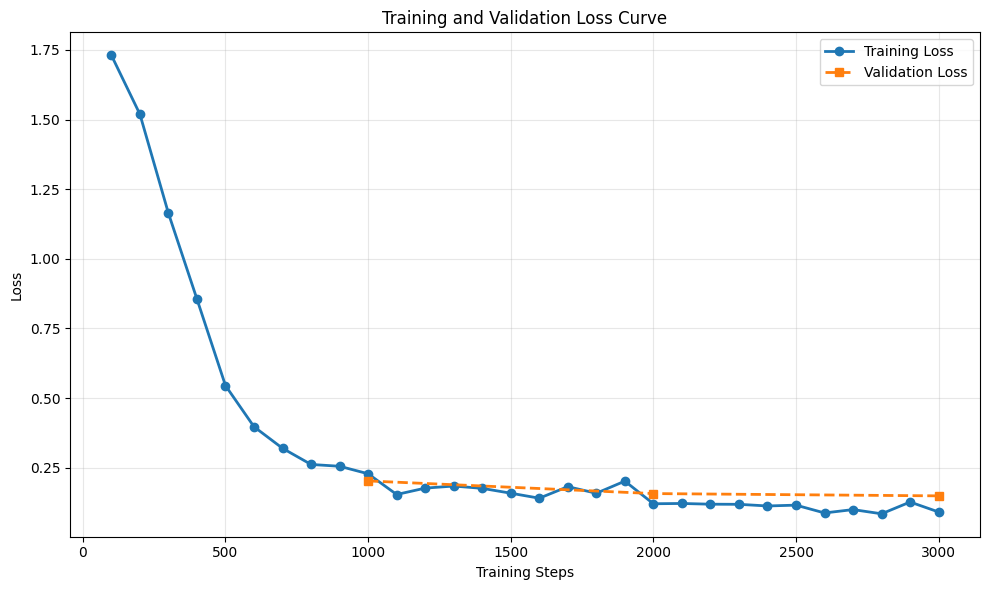

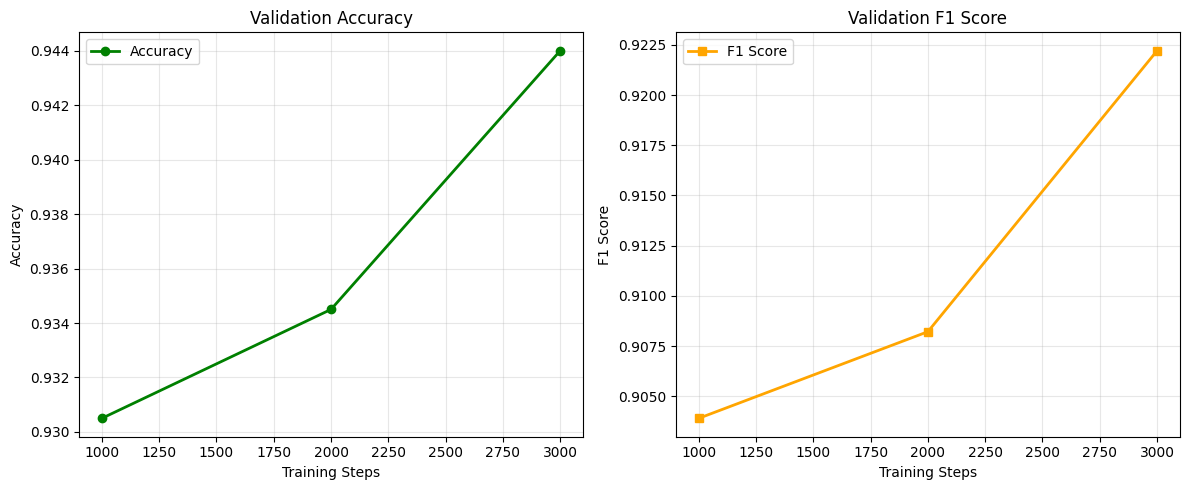


Evaluating on test set...



Test set results:
Accuracy: 0.9225
F1 Score: 0.8761
Loss: 0.1826

Saving model...


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


Training completed!
Best model saved at: ./emotion_model/checkpoint-checkpoint-3000


In [15]:

def compute_metrics(eval_pred):
    """
    Compute accuracy and F1 score for evaluation.
    """
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)


    accuracy = accuracy_score(labels, predictions)

    f1 = f1_score(labels, predictions, average='macro')

    return {
        'accuracy': accuracy,
        'f1': f1
    }


training_args = TrainingArguments(
    output_dir="./emotion_model",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none",
    learning_rate=2e-5,
    save_total_limit=2,
    metric_for_best_model="f1",
    greater_is_better=True,
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)


print("Starting training...")
trainer.train()


def plot_training_loss(trainer):
    """
    Plot training loss curve from trainer state.
    """
    train_loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
    eval_loss = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]
    steps = [log['step'] for log in trainer.state.log_history if 'loss' in log]

    plt.figure(figsize=(10, 6))
    plt.plot(steps, train_loss, label='Training Loss', marker='o', linestyle='-', linewidth=2)

    if eval_loss:
        eval_steps = [log['step'] for log in trainer.state.log_history if 'eval_loss' in log]
        plt.plot(eval_steps, eval_loss, label='Validation Loss', marker='s', linestyle='--', linewidth=2)

    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Curve')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


    if any('eval_accuracy' in log for log in trainer.state.log_history):
        eval_accuracy = [log['eval_accuracy'] for log in trainer.state.log_history if 'eval_accuracy' in log]
        eval_f1 = [log['eval_f1'] for log in trainer.state.log_history if 'eval_f1' in log]
        eval_steps = [log['step'] for log in trainer.state.log_history if 'eval_accuracy' in log]

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

        ax1.plot(eval_steps, eval_accuracy, label='Accuracy', marker='o', color='green', linewidth=2)
        ax1.set_xlabel('Training Steps')
        ax1.set_ylabel('Accuracy')
        ax1.set_title('Validation Accuracy')
        ax1.grid(True, alpha=0.3)
        ax1.legend()

        ax2.plot(eval_steps, eval_f1, label='F1 Score', marker='s', color='orange', linewidth=2)
        ax2.set_xlabel('Training Steps')
        ax2.set_ylabel('F1 Score')
        ax2.set_title('Validation F1 Score')
        ax2.grid(True, alpha=0.3)
        ax2.legend()

        plt.tight_layout()
        plt.show()


plot_training_loss(trainer)

print("\nEvaluating on test set...")
test_results = trainer.evaluate(tokenized_datasets["test"])
print(f"\nTest set results:")
print(f"Accuracy: {test_results['eval_accuracy']:.4f}")
print(f"F1 Score: {test_results['eval_f1']:.4f}")
print(f"Loss: {test_results['eval_loss']:.4f}")


print("\nSaving model...")
trainer.save_model("./emotion_final_model")


print("\nTraining completed!")
if hasattr(trainer.state, 'best_model_checkpoint') and trainer.state.best_model_checkpoint:
    checkpoint_num = trainer.state.best_model_checkpoint.split('/')[-1]
    print(f"Best model saved at: ./emotion_model/checkpoint-{checkpoint_num}")

In [17]:
custom_texts = [
    "I'm so excited about my birthday party tomorrow!",
    "I can't believe my best friend moved away. I miss her so much.",
    "That referee made the worst call! This is ridiculous!",
    "I heard footsteps behind me in the dark alley.",
    "Wait, you're pregnant?! I had no idea!",
    "You make my heart skip a beat every time I see you."
]

# Tokenize custom texts
inputs = tokenizer(custom_texts, return_tensors="pt", padding=True, truncation=True, max_length=128)

# Move inputs to model device (GPU/CPU)
device = trainer.model.device
inputs = {k: v.to(device) for k, v in inputs.items()}

# Predict
trainer.model.eval()
with torch.no_grad():
    outputs = trainer.model(**inputs)
    probs = torch.softmax(outputs.logits, dim=-1).cpu().numpy()

for text, prob in zip(custom_texts, probs):
    pred_id = np.argmax(prob)
    confidence = prob[pred_id]
    pred_label = emotion_labels[pred_id]

    print(f"\nText: {text}")
    print(f"Predicted Emotion: {pred_label} | Confidence: {confidence:.4f}")


Text: I'm so excited about my birthday party tomorrow!
Predicted Emotion: joy | Confidence: 0.9974

Text: I can't believe my best friend moved away. I miss her so much.
Predicted Emotion: sadness | Confidence: 0.9940

Text: That referee made the worst call! This is ridiculous!
Predicted Emotion: anger | Confidence: 0.8353

Text: I heard footsteps behind me in the dark alley.
Predicted Emotion: fear | Confidence: 0.9777

Text: Wait, you're pregnant?! I had no idea!
Predicted Emotion: anger | Confidence: 0.8136

Text: You make my heart skip a beat every time I see you.
Predicted Emotion: anger | Confidence: 0.5249
